In [1]:
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from textblob import TextBlob

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

In [2]:
def get_numeric_columns(df):
    """
    Returns numerical column names as a list
    :param df: pandas Dataframe
    :return list of column names
    """
    return df.select_dtypes(include=[np.number]).columns.tolist()

In [3]:
def get_categorical_columns(df):
    """
    Returns categorical column names as a list
    :param df: pandas Dataframe
    :return list of column names
    """
    return df.select_dtypes(exclude=[np.number]).columns.tolist()

In [4]:
def clean_data(df):
    """
    Drops redundant, encoded, highly null columns 
    Encodes categorical columns
    Creates new features out of free text columns
    Drops rows that has na in any columns
    :param df: pandas Dataframe
    :return cleansed pandas Dataframe
    """
    
    # Drop columns that have single value or might introduce high dimensions
    redundant_columns = ['id', 
                         'listing_url', 
                         'thumbnail_url', 
                         'medium_url',
                         'picture_url',
                         'xl_picture_url', 
                         'host_url',
                         'host_thumbnail_url',
                         'host_picture_url',
                         'calendar_updated', 
                         'name',
                         'summary', 
                         'space', 
                         'notes',
                         'host_about',
                         'host_name', 
                         'host_neighbourhood', 
                         'host_location',
                         'host_verifications', 
                         'neighbourhood', 
                         'neighbourhood_cleansed',
                         'street',
                         'city',
                         'state',
                         'zipcode',
                         'smart_location',
                         'scrape_id',
                         'calendar_last_scraped',
                         'experiences_offered',
                         'market',
                         'country_code',
                         'country',
                         'has_availability',
                         'requires_license',
                         'jurisdiction_names', 
                         'weekly_price', 
                         'monthly_price',
                         'host_listings_count', 
                         'host_total_listings_count']

    
    # Drop columns with percentage of NaN > %90
    # df.dropna(axis=1, thresh=int(df.shape[0]*0.9), inplace=True)    
    high_na_columns = ['square_feet','license']
    
    # Instead of using date columns, new features are generated
    date_columns = ['first_review', 'last_review', 'host_since', 'last_scraped']
    
    rate_columns = ['host_response_rate', 'host_acceptance_rate']
    monetary = ['price','security_deposit', 'cleaning_fee', 'extra_people']
    
    boolean = ['host_is_superhost', 
               'host_has_profile_pic', 
               'host_identity_verified', 
               'is_location_exact', 
               'instant_bookable',
               'require_guest_profile_picture',
               'require_guest_phone_verification']
    
    # Convert string to datetime
    for col in date_columns:
        df[col] = pd.to_datetime(df[col])
    
    # Following two features considered to indicate popularity 
    df['time_to_first_review'] = (df['first_review'] - df['host_since']).dt.days
    df['time_since_last_review'] = (df['last_scraped'] - df['last_review']).dt.days

    
    # Remove special characters from monetary and percentage columns and cast to integer
    for col in monetary+rate_columns:
        df[col] = df[col].apply(lambda val: 
                                re.sub(r'[^a-zA-Z0-9]', '', str(val)) 
                                if val is not np.nan 
                                else 0).\
        astype('int')
   
    numeric_columns = get_numeric_columns(df)
    # Convert t/f to 1/0 in boolean columns
    for col in boolean:
        df[col] = df[col].apply(lambda val: 1 if val=='t' else 0)
        
    
    
    exclude=['price','latitude','longitude','availability_30','availability_60','availability_90','availability_365']
    

    # Get dummies for amenities
    df = pd.concat([df.drop('amenities',axis=1), 
                   df.amenities.apply(
                       lambda val: re.sub('[^a-zA-Z0-9\,]',' ', val).replace(' ','').split(',')).
                   str.join('|').
                   str.get_dummies()],
                  axis=1)
    df.drop(
        columns=redundant_columns+high_na_columns+date_columns,
        axis=1, inplace=True)
    
    numeric_columns = [col for col in numeric_columns if col not in exclude+redundant_columns+high_na_columns+date_columns]

    obj_columns = get_categorical_columns(df) 
    for col in obj_columns:
        df[col] = df[col].apply(lambda val: re.sub('[^a-zA-Z0-9]', ' ', str(val)).lower().strip(' '))
        
    sentiment_columns = ['neighborhood_overview', 'description', 'transit']
    df['neighborhood_polarity'] = df['neighborhood_overview'].apply(lambda val :  TextBlob(val).sentiment.polarity)    
    df['description_polarity'] = df['description'].apply(lambda val :  TextBlob(val).sentiment.polarity)
    df['transit_polarity'] = df['transit'].apply(lambda val :  TextBlob(val).sentiment.polarity)
    
    df.drop(columns=sentiment_columns, axis=1, inplace=True)    
    
    df['neighbourhood_group_cleansed'] = pd.Categorical(df['neighbourhood_group_cleansed'])
    df['neighbourhood_group_cleansed'] = df['neighbourhood_group_cleansed'].cat.codes
    
    numeric_columns = numeric_columns + ['neighbourhood_group_cleansed']
    obj_columns = [col for col in obj_columns if col not in sentiment_columns+['neighbourhood_group_cleansed']]
    
    for col in obj_columns:
        df[col] = df[col].apply(lambda val: np.nan if val=='nan' else val)
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], dummy_na=False ,drop_first=True)],axis=1)
    df.dropna(inplace=True)
    return df

In [5]:
def create_train_test_data(df, test_size=0.33, random_state=23):
    """
    Creates input(X) and label(y) datasets, splits these datasets into test and train subsets
    Scales the test and train input subsets
    :param df: pandas Dataframe
    :param test_size:  proportion of the dataset to include in the test split
    :param random_state: seed used by the random number generator
    :return cleansed pandas Dataframe and numerical columns list
    """
    
    X = df.drop(columns=['price'], axis=1)
    y = df.price
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    scaler = StandardScaler()
    sc_X_train = pd.DataFrame(scaler.fit_transform(X_train))
    sc_X_train.columns = X_train.columns
    

    sc_X_test = pd.DataFrame(scaler.transform(X_test))
    sc_X_test.columns = X_test.columns
 
    return sc_X_train, y_train, sc_X_test, y_test

In [6]:
def get_best_params(X_train, y_train):

    param_grid={'n_estimators': range(50,500,100), 'max_depth':[None,5,20]}
    model = RandomForestRegressor(random_state=17)
    clf = GridSearchCV(model, param_grid = param_grid, scoring='r2', cv=3, return_train_score=True)
    clf.fit(X_train, y_train)
#     clf.cv_results_['mean_train_score']
    return clf.best_params_

In [7]:
def train_and_predict(X_train, y_train, X_test, y_test, **params):
    model = RandomForestRegressor( n_estimators=params.get('n_estimators'), max_depth=params.get('max_depth'), random_state=17)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    print(r2_score(y_test, y_preds))
    return (model, y_preds)

In [8]:
def plot_error_hist(diff, save):
    fig = plt.figure(figsize=(20,15))
    ax = fig.gca()
    diff.hist(bins = 40, ax=ax)
    plt.title('Histogram of prediction errors')
    plt.xlabel('Prediction error')
    plt.ylabel('Frequency')
    if save:
        plt.savefig('figures/pred_error_hist.png')

In [9]:
def plot_measure_vs_preds(y_test, y_preds, save):
    fig = plt.figure(figsize=(30,15))
    ax = fig.gca()
    ax.scatter(y_test, y_preds)

    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    if save:
        plt.savefig('figures/meas_vs_pred.png')    


In [10]:
def plot_results(y_test, y_preds, save=False):
    plot_measure_vs_preds(y_test, y_preds, save)
    diff = y_test-y_preds
    plot_error_hist(diff, save)

In [11]:
def print_feature_importances(X, model):
    imps = pd.DataFrame()
    imps['feature'] = X.columns
    imps['coefficient'] = model.feature_importances_
    imps = imps.sort_values('coefficient', ascending=False)
    print(imps.reset_index().head(n=10))
    print('\n')
    print(imps.reset_index().tail(n=10))

In [12]:
listings = pd.read_csv("data/listings.csv")

In [13]:
clean_listings = clean_data(listings)

/Users/surmelie1/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int8, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/surmelie1/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int8, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/surmelie1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype int8, uint8, int64, float64 were all converted to float64 by StandardScaler.


0.6290531199886635
   index               feature  coefficient
0     12              bedrooms     0.413892
1     15          cleaning_fee     0.053380
2    101          private room     0.039854
3     81  description_polarity     0.036671
4     14      security_deposit     0.030007
5     10          accommodates     0.029731
6      7              latitude     0.027472
7     36     reviews_per_month     0.027280
8     11             bathrooms     0.025478
9     23      availability_365     0.023142


     index      feature   coefficient
99      87         boat  2.537632e-05
100    104        futon  2.287703e-05
101     88     bungalow  1.318606e-05
102     97         tent  3.504029e-06
103    103        couch  1.467742e-06
104     93         dorm  1.664894e-07
105    100         yurt  1.525179e-07
106     91       chalet  5.064678e-08
107     99    treehouse  0.000000e+00
108     77  WasherDryer  0.000000e+00


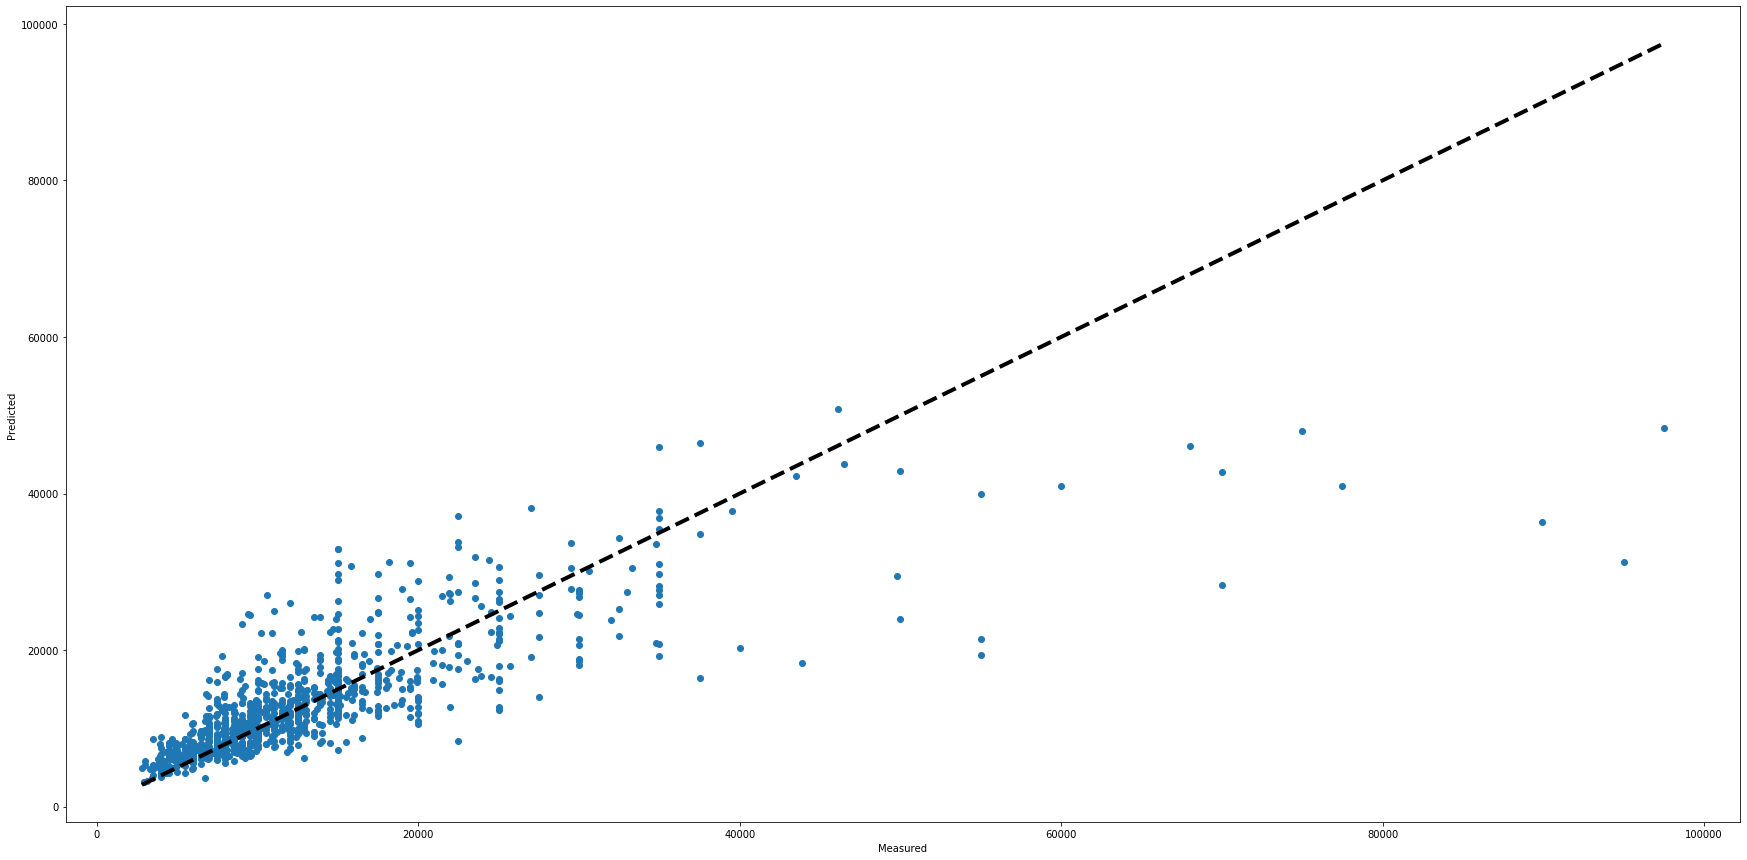

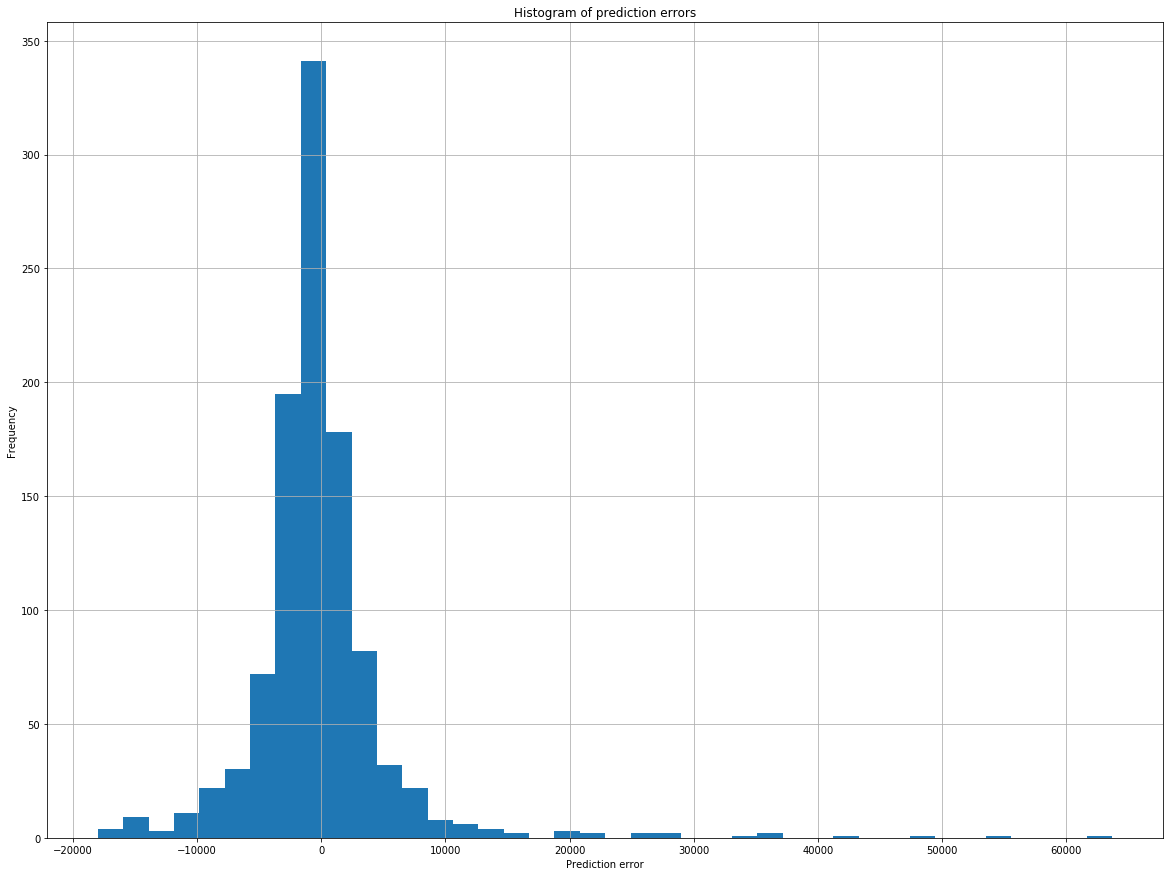

In [14]:
X_train, y_train, X_test, y_test = create_train_test_data(clean_listings)
params = get_best_params(X_train, y_train)
model, y_preds = train_and_predict(X_train, y_train, X_test, y_test, **params)
plot_results(y_test, y_preds, save=True)
print_feature_importances(X_train, model)